## VARIATIONAL QUANTUM CLASSIFIER WITH QISKIT ##

# aggiungere qualcosa di confronto con altri modelli (magari classici)

The variational quantum classifier (VQC) is an hybrid quantum-classical classifier. The main idea is to use a parametrized quantum circuit iteratively with better and better parameters.

In more details:
We prepare our initial state with a feature map to encode classical data in the initial quantum state. Then we build a quantum circuit that applies some different rotations of angles $\theta_1, \cdots, \theta_l $ and other gates. Finally we collapse each qubit's wave function with a measurement. Here the classical part begins: we choose a loss function that takes the physical final state as an argument and a classical algorithm to minimize the loss function. Then we use the new parameters values to apply different rotations in the quantum circuit. So we iterate until an acceptance criterion is met.

In [1]:
#!pip install imblearn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder, StandardScaler
#import random
import qiskit_ibm_runtime as IBMR
#from qiskit_ibm_runtime import QiskitRuntimeService

from sklearn import linear_model, svm
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap, RealAmplitudes, NLocal, TwoLocal, EfficientSU2, EvolvedOperatorAnsatz, ExcitationPreserving, QAOAAnsatz

from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP

from qiskit import QuantumCircuit

from qiskit.primitives import Sampler

from qiskit_machine_learning.algorithms.classifiers import VQC  

from IPython.display import clear_output

from qiskit import BasicAer, execute

from qiskit_machine_learning.circuit.library import RawFeatureVector

from qiskit.providers.fake_provider import FakeAuckland
from qiskit_aer.noise import NoiseModel

from qiskit_ibm_runtime import QiskitRuntimeService, Options, Session, Estimator

from qiskit import IBMQ
#provider = IBMQ.load_account()

import warnings
warnings.filterwarnings('ignore')



/var/folders/72/24j7jy9s6sb2xm_dc84kdhm00000gn/T/ipykernel_69486/400081932.py:20: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP


In [3]:
np.random.seed(42)

In [4]:
file_path = "dataset/dataset.csv"

In [5]:
try:
    df = pd.read_csv(file_path)
    print("Dataset imported successfully.")
except FileNotFoundError:
    print("File not found. Please check the file path.")
    exit()

Dataset imported successfully.


In [6]:
df.drop(columns=['step'], inplace=True)
df.drop(columns=['zipcodeOri'], inplace=True)
df.drop(columns=['zipMerchant'], inplace=True)
df.drop(columns=['customer'], inplace=True)
df.drop(columns=['merchant'], inplace=True)

print(df.head())

   age gender             category  amount  fraud
0  '4'    'M'  'es_transportation'    4.55      0
1  '2'    'M'  'es_transportation'   39.68      0
2  '4'    'F'  'es_transportation'   26.89      0
3  '3'    'M'  'es_transportation'   17.25      0
4  '5'    'M'  'es_transportation'   35.72      0


In [7]:
encoder = LabelEncoder()

encoded_age = encoder.fit_transform(df['age'])
df['age'] = encoded_age
encoded_gender = encoder.fit_transform(df['gender'])
df['gender'] = encoded_gender
encoded_category = encoder.fit_transform(df['category'])
df['category'] = encoded_category

print(df.head())

   age  gender  category  amount  fraud
0    4       2        12    4.55      0
1    2       2        12   39.68      0
2    4       1        12   26.89      0
3    3       2        12   17.25      0
4    5       2        12   35.72      0


Undersampling to have a balanced dataset:

In [8]:
X = df.drop('fraud', axis=1)
y = df['fraud']

# Check class distribution
print("Class distribution before undersampling:")
print(y.value_counts())

#---------------------------------------------------------------------------
# To have only 100 fraud and 100 non-fraud samples
sampling_strategy = {0: 100, 1: 100}
#---------------------------------------------------------------------------

# Undersample the majority class
undersample = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = undersample.fit_resample(X, y)

# Check class distribution after undersampling
print("Class distribution after undersampling:")
print(pd.Series(y_resampled).value_counts())

Class distribution before undersampling:
fraud
0    587443
1      7200
Name: count, dtype: int64
Class distribution after undersampling:
fraud
0    100
1    100
Name: count, dtype: int64


In [9]:
X_resampled = MinMaxScaler().fit_transform(X_resampled)

Train test split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=0)
print(X_train.shape, X_test.shape)

(140, 4) (60, 4)


To use the Amplitude encoding feature map we have to do a different data preprocessing:
In the amplitude encoding we want to encode our data in the amplitudes of our initial quantum state. To do so we need to make the size of the padded data point to match the size of the state vector in the quantum device.

(In our case we selected $4=2^2$ features so we don't need it)

In [11]:
# num_examples, num_features = X_resampled.shape 

# n = int(np.ceil(np.log2(num_features)))
# dim = 2**n
# print(f'(number of qubits, dimension of the Hilbert space) = {(n, dim)}')

# zeros = np.zeros((num_examples, dim-num_features))
# X_resampled_amp = np.append(X_resampled, zeros, axis=1)
# num_examples, num_features = X_resampled_amp.shape
  
# print("number of examples = ", num_examples)
# print("number of features = ", num_features)

In [12]:
# X_train_amp, X_test_amp, y_train_amp, y_test_amp = train_test_split(X_resampled_amp, y_resampled, test_size=0.3, random_state=0)

# QUANTUM FEATURE MAP:

Quantum feature maps are used to transform classical data into a quantum state that can be processed by a quantum computer. In a quantum feature map, the input data is transformed using a quantum gates operation to produce a new quantum state vector that contains higher-order correlations between the original data points 
$$\ket{\Psi(\vec{x})} = V_{\Phi(\vec{x})} \ket{0}^{\otimes N} $$
The quantum feature maps are able to efficiently generate complex transformation that are computationally hard to construct using classical method. Moreover, the base quantum circuit operation can also be repeated multiple times to construct more complex feature maps.

# Pauli feature map

Pauli feature map is a class of feature maps, in general it transforms input data with $N$ features $\vec{x}\in \mathbb{R}^N$ into quantum information in $N$ qubits $\ket{\Psi(\vec{x})}$. It can be described as unitary operator below:
$$V_{\Phi(\vec{x})} = U_{\Phi(\vec{x})} H^{\otimes N}\dots  U_{\Phi(\vec{x})} H^{\otimes N}$$
$U_{\Phi(\vec{x})} H^{\otimes N}$ represents the Pauli expansion matrix:
$$U_{\Phi(\vec{x})} = e^{i\sum_{S\subseteq I}\alpha \psi_{S}(\vec{x})\prod_{j\in S}P_j}$$
where $I$ is the set of qubit indices describing the connections in the feature map and $\psi_{S}(\vec{x})$ is the data mapping function.
$$\psi_{S}(\vec{x}) =  \begin{cases} x_j \quad\quad & \text{if } S=\{x_j\} \\ \prod_{j\in S}(\pi - x_j) \quad\quad & \text{if } |S|>1 \end{cases} $$
$P_j \in \{I, X, Y, Z\}$ represents the Pauli matrices and $\alpha$ is a variable to adjust the magnitude of Pauli rotation gates.
In the PauliFeatureMap class in Qiskit Python package we can specify the number of repetitions of the feature map to have more accurate representation; the entanglement type to represent the entanglement structure among qubits (linear, reverse linear, circular, full).

# Z feature map

The Z feature map is a first-order Pauli-Z evolution circuit. It's a specialization of the Pauli feature map. Z feature map is particularly well-suited for specific application where quantum circuit without entanglement is desired beacuse of the absence of entangling gates.

# ZZ feature map

The ZZ feature map is a second-order Pauli-Z evolution circuit. It is only a special case of Pauli feature maps with Pauli sequence $[Z, ZZ]$. The rotation blocks apply single-qubit rotations based on the classical data, parametrised by angles determined by a $\psi$. In our case, with four features we have $\psi(x,y,z,w) = (\pi-x)(\pi-y)(\pi-z)(\pi-w)$.

# Raw Feature Vector

The RawFeatureVector is part of the amplitude encoding feature map class. The idea is to encode the data in the amplitudes of the initial quantum state.

We try different feature map to encode our data:

- PauliFeatureMap
- ZFeatureMap
- ZZFeatureMap
- RawFeatureVector

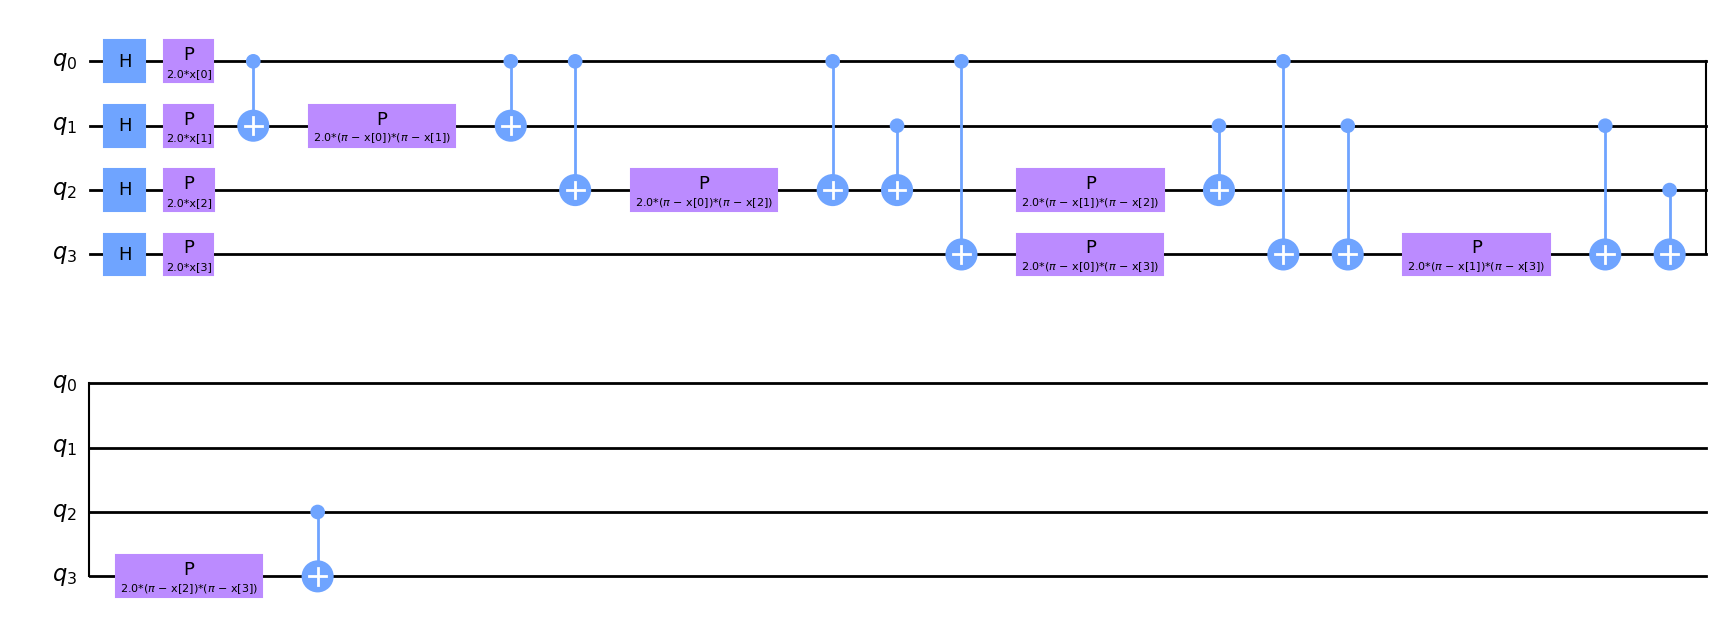

In [13]:
ZZ = ZZFeatureMap(feature_dimension=4, reps=1)   # feature_dimension = num_features       
ZZ.decompose().draw(output='mpl')



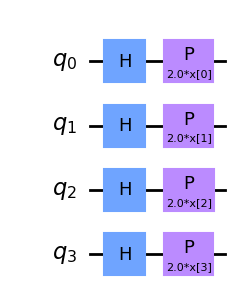

In [14]:
Z = ZFeatureMap(feature_dimension=4, reps=1)   # feature_dimension = num_features
Z.decompose().draw(output='mpl')

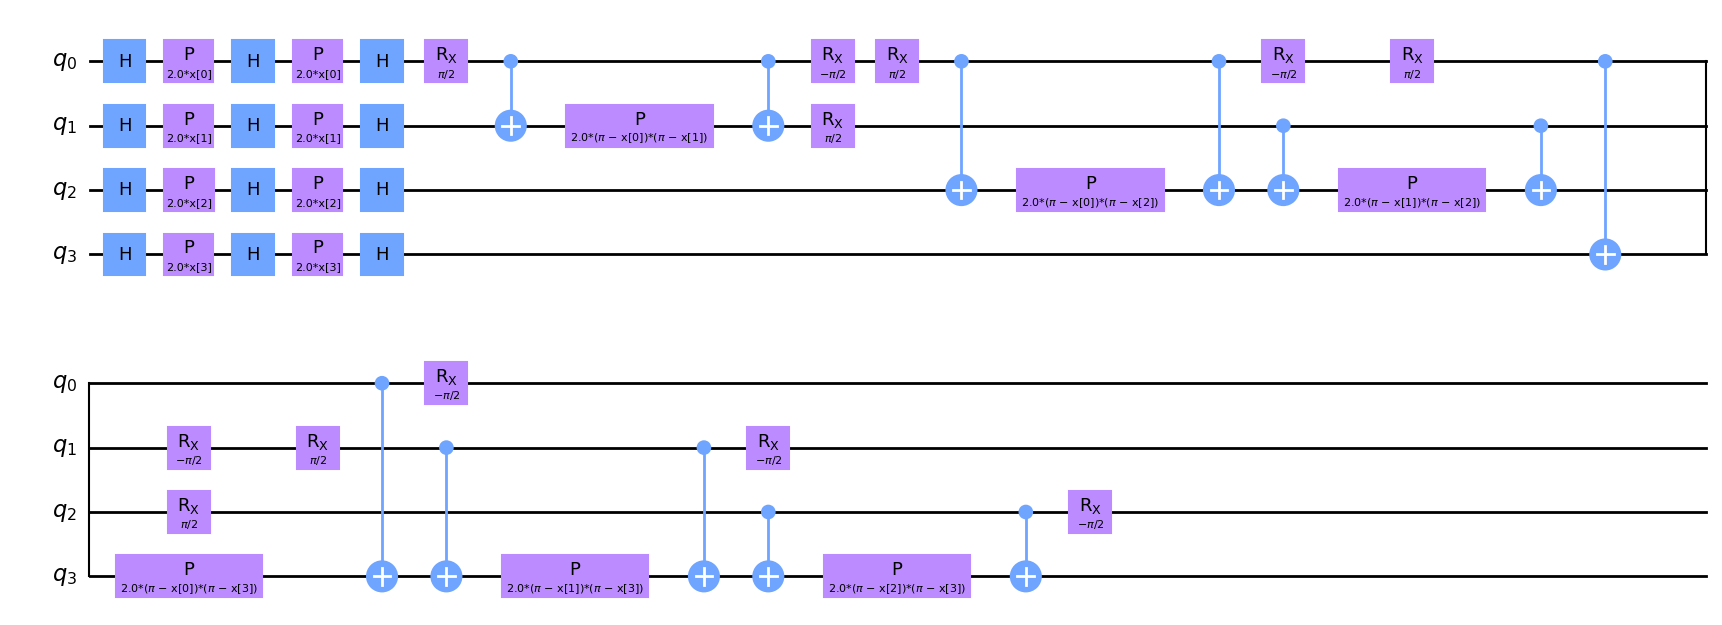

In [15]:
P = PauliFeatureMap(feature_dimension=4, reps=1, paulis=['Z','X','ZY'])   # feature_dimension = num_features
P.decompose().draw(output='mpl')

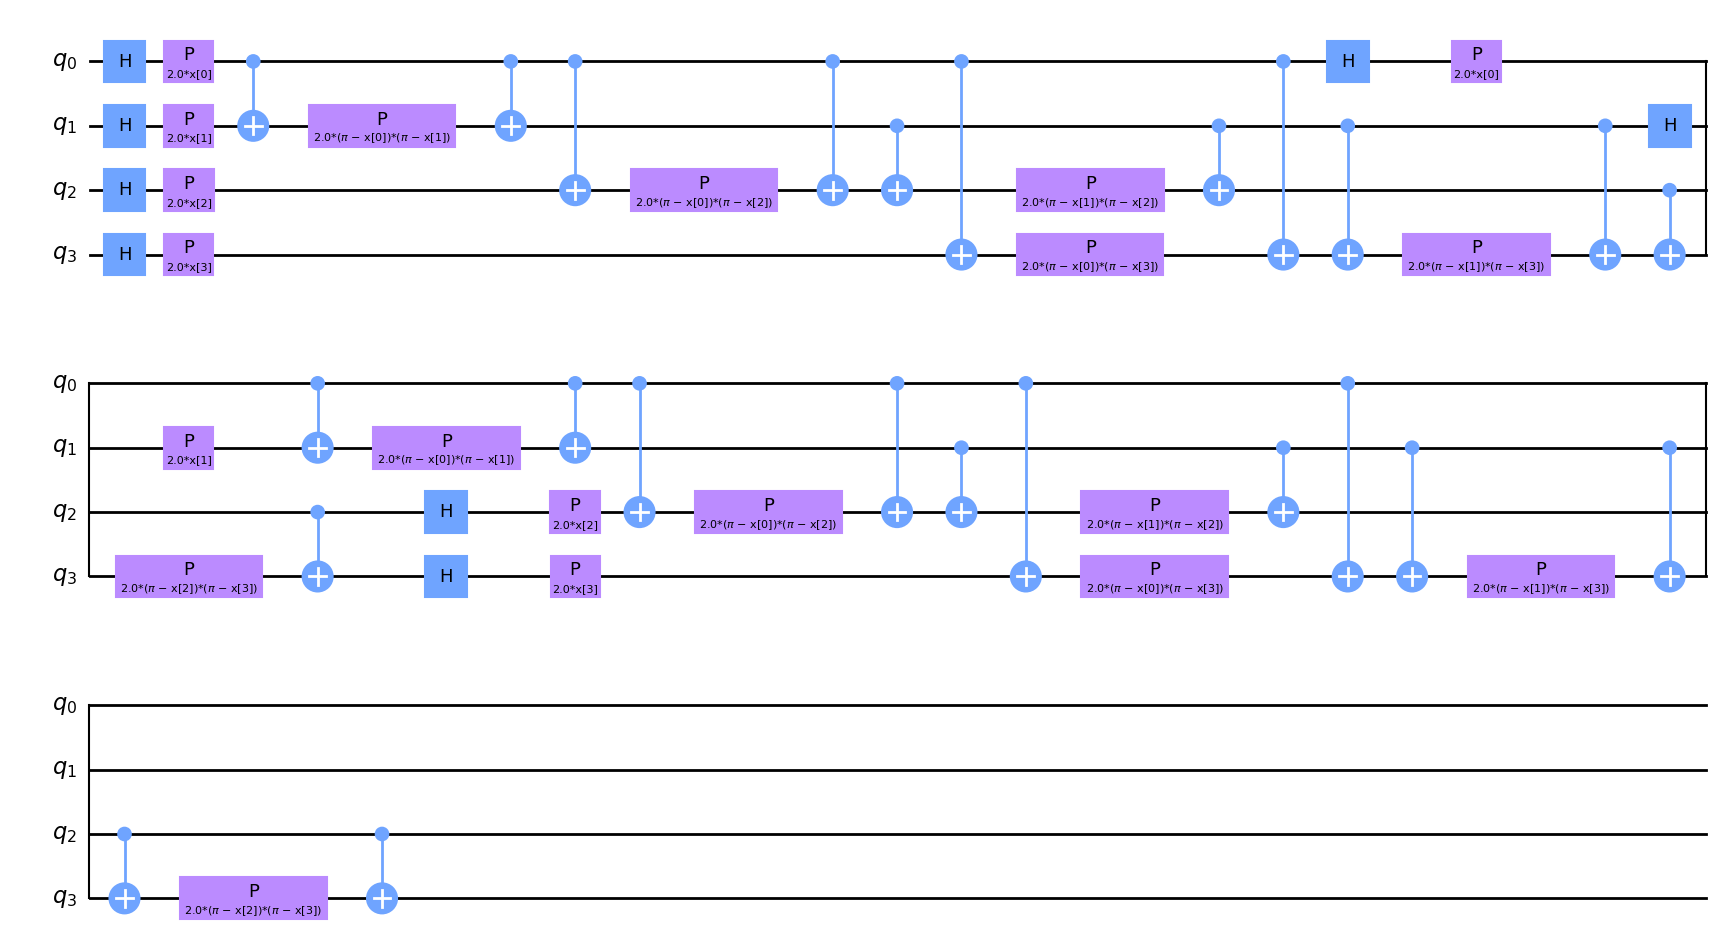

In [16]:
ZZ2 = ZZFeatureMap(feature_dimension=4, reps=2)   # feature_dimension = num_features       
ZZ2.decompose().draw(output='mpl')

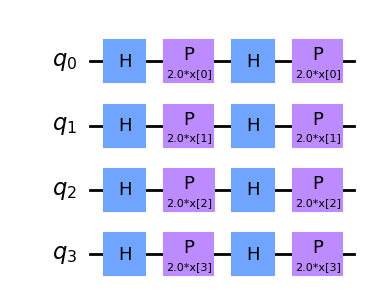

In [17]:
Z2 = ZFeatureMap(feature_dimension=4, reps=2)   # feature_dimension = num_features
Z2.decompose().draw(output='mpl')

In [18]:
# amp_enc = RawFeatureVector(feature_dimension=num_features)
# amp_enc.draw(output = 'mpl') 

Parametrized Quantum Circuits

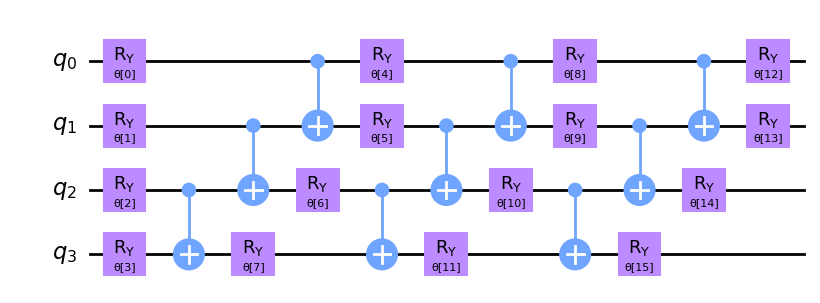

In [19]:
pqc = RealAmplitudes(num_qubits=4, reps=3)  # num_qubits = num_features
pqc.decompose().draw(output='mpl')

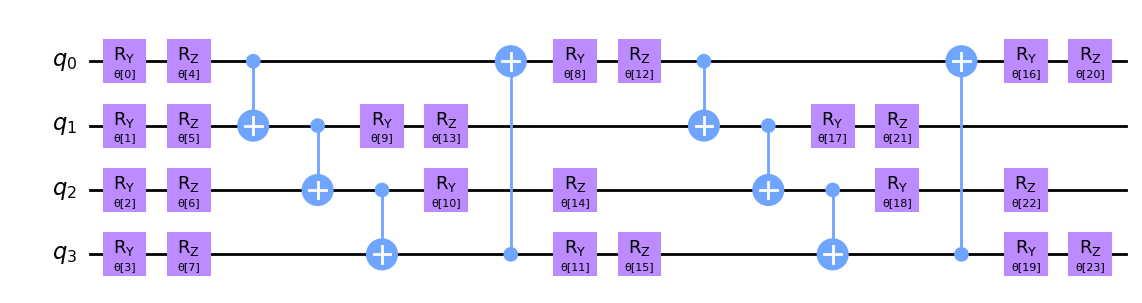

In [20]:
from qiskit.circuit import Parameter
num_qubits = 4

parameters_ry = [Parameter(f'phi_{i}') for i in range(num_qubits)]
parameters_rz = [Parameter(f'theta_{i}') for i in range(num_qubits)]

qc = QuantumCircuit(num_qubits)
for q, parameter in enumerate(parameters_ry):
    qc.ry(parameter, q)
for q, parameter in enumerate(parameters_rz):
    qc.rz(parameter, q)

ent = QuantumCircuit(num_qubits)
for q in range(num_qubits):
    ent.cx(q, (q + 1) % 4)

nlocal = NLocal(num_qubits=4, rotation_blocks=[qc],entanglement_blocks= ent, reps=2, insert_barriers=False)
nlocal.decompose().draw(output='mpl')

In [21]:
# pqc_amp = RealAmplitudes(num_qubits=n, reps=3)
# pqc_amp.decompose().draw(output = 'mpl')

There are three types of Optimizers:

- COBYLA (Constrained Optimization By Linear Approximation optimizer.)
- SPSA (Simultaneous Perturbation Stochastic Approximation optimizer.)
- SLSQP (Sequential Least Squares Programming optimize)

- COBYLA

COBYLA (Constrained Optimization BY Linear Approximation) is a gradient-free optimization algorithm that uses a linear approximation of the function in the neighborhood of the current point to determine the next point to evaluate. The algorithm is based on the idea of "trust regions," which means that the algorithm only considers changes to the variables that are within a certain "trust region" around the current point. It is particularly useful when the objective function is expensive to evaluate or is non-differentiable. It is also well-suited for problems with constraints, as it can handle both equality and inequality constraints.
The COBYLA algorithm has two important parameters: rhobeg and maxiter. rhobeg determines the size of the initial "trust region" around the starting point, and maxiter specifies the maximum number of iterations the algorithm can perform before terminating. In general, smaller values of rhobeg will lead to more accurate results, but may also increase the computational cost of the algorithm.

- SPSA

SPSA is a general method for minimizing differentiable multivariate functions. It is particularly useful for functions for which evaluating the gradient is not possible, or too resource intensive. SPSA provides a stochastic method for approximating the gradient of the cost function. To accomplish this, the cost function is evaluated twice using perturbed parameter vectors: every component of the original parameter vector is simultaneously shifted with a randomly generated value. This is in contrast to finite-differences methods where for each evaluation only one component of the parameter vector is shifted at a time.

- SLSQP

SLSQP optimizer is a sequential least squares programming algorithm which uses the Han-Powell quasi-Newton method with a BFGS update of the B-matrix and an L1-test function in the step-length algorithm. The optimizer uses a slightly modified version of Lawson and Hanson’s NNLS nonlinear least-squares solver.

In [22]:
optimizer = COBYLA(maxiter=150)
#service = QiskitRuntimeService()
#backend = service.get_backend("simulator_statevector")
#sampler = IBMR.Sampler(backend=backend)

sampler = Sampler() # We use a simulator. We create an instance of the Sampler primitive.
# We sismulate with the statevector simulator so we simulate ideal quantum state evolution.


#initial_point_amp=np.random.random(pqc_amp.num_parameters)

initial_point=np.random.random(pqc.num_parameters)

objective_func_vals = {'Z': [], 'ZZ': [], 'P': [], 'Z2' : [], 'ZZ2' : []} #, 'Amp': []}

def callback(feature_map_name, obj_func_eval):
    # Append objective function value to the corresponding list based on the feature map name
    objective_func_vals[feature_map_name].append(obj_func_eval)

def plot_objective_function_values():
    clear_output(wait=True)
    
    # Plot all objective function values
    
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    for feature_map_name, obj_func_vals in objective_func_vals.items():
        plt.plot(range(len(obj_func_vals)), obj_func_vals, label=feature_map_name)
    plt.legend()
    plt.show()

# In Qiskit, the default loss function is cross entropy

vqc_Z = VQC(
    sampler=sampler,
    feature_map=Z,
    ansatz=pqc,
    initial_point=initial_point,
    optimizer=optimizer,
    callback=lambda weights, obj_func_eval: callback('Z', obj_func_eval),
)

vqc_ZZ = VQC(
    sampler=sampler,
    feature_map=ZZ,
    ansatz=pqc,
    initial_point=initial_point,
    optimizer=optimizer,
    callback=lambda weights, obj_func_eval: callback('ZZ', obj_func_eval),
)

vqc_P = VQC(
    sampler=sampler,
    feature_map=P,
    ansatz=pqc,
    initial_point=initial_point,
    optimizer=optimizer,
    callback=lambda weights, obj_func_eval: callback('P', obj_func_eval),
)

vqc_Z2 = VQC(
    sampler=sampler,
    feature_map=Z2,
    ansatz=pqc,
    initial_point=initial_point,
    optimizer=optimizer,
    callback=lambda weights, obj_func_eval: callback('Z2', obj_func_eval),
)

vqc_ZZ2 = VQC(
    sampler=sampler,
    feature_map=ZZ2,
    ansatz=pqc,
    initial_point=initial_point,
    optimizer=optimizer,
    callback=lambda weights, obj_func_eval: callback('ZZ2', obj_func_eval),
)

# vqc_amp = VQC(
#     sampler=sampler,
#     feature_map=amp_enc,
#     ansatz=pqc_amp,
#     initial_point=initial_point_amp,
#     optimizer=optimizer,
#     callback=lambda weights, obj_func_eval: callback('Amp', obj_func_eval),
# )

In [23]:
objective_func_vals_nloc = {'Z': [], 'ZZ': [], 'P': [], 'Z2' : [], 'ZZ2' : []}

initial_point_nloc=np.random.random(nlocal.num_parameters)

def callback_nloc(feature_map_name, obj_func_eval):
    # Append objective function value to the corresponding list based on the feature map name
    objective_func_vals_nloc[feature_map_name].append(obj_func_eval)

def plot_objective_function_values_nloc():
    clear_output(wait=True)
    
    # Plot all objective function values
    
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    for feature_map_name, obj_func_vals in objective_func_vals_nloc.items():
        plt.plot(range(len(obj_func_vals)), obj_func_vals, label=feature_map_name)
    plt.legend()
    plt.show()

vqc_Z_nloc = VQC(
    sampler=sampler,
    feature_map=Z,
    ansatz=nlocal,
    initial_point=initial_point_nloc,
    optimizer=optimizer,
    callback=lambda weights, obj_func_eval: callback_nloc('Z', obj_func_eval),
)

vqc_ZZ_nloc = VQC(
    sampler=sampler,
    feature_map=ZZ,
    ansatz=nlocal,
    initial_point=initial_point_nloc,
    optimizer=optimizer,
    callback=lambda weights, obj_func_eval: callback_nloc('ZZ', obj_func_eval),
)

vqc_P_nloc = VQC(
    sampler=sampler,
    feature_map=P,
    ansatz=nlocal,
    initial_point=initial_point_nloc,
    optimizer=optimizer,
    callback=lambda weights, obj_func_eval: callback_nloc('P', obj_func_eval),
)

vqc_Z2_nloc = VQC(
    sampler=sampler,
    feature_map=Z2,
    ansatz=nlocal,
    initial_point=initial_point_nloc,
    optimizer=optimizer,
    callback=lambda weights, obj_func_eval: callback_nloc('Z2', obj_func_eval),
)

vqc_ZZ2_nloc = VQC(
    sampler=sampler,
    feature_map=ZZ2,
    ansatz=nlocal,
    initial_point=initial_point_nloc,
    optimizer=optimizer,
    callback=lambda weights, obj_func_eval: callback_nloc('ZZ2', obj_func_eval),
)

In [24]:
# vqc.fit wants ndarray as input

y_train_np = y_train.values
y_test_np = y_test.values

# y_train_np_amp = y_train_amp.values
# y_test_np_amp = y_test_amp.values

In [25]:
%%time
vqc_Z.fit(X_train, y_train_np)

CPU times: user 3min 35s, sys: 1.37 s, total: 3min 36s
Wall time: 3min 38s


In [26]:
%%time
vqc_ZZ.fit(X_train, y_train_np)

CPU times: user 5min 37s, sys: 2.08 s, total: 5min 39s
Wall time: 5min 41s


In [27]:
%%time
vqc_P.fit(X_train, y_train_np)

CPU times: user 6min 38s, sys: 2.5 s, total: 6min 40s
Wall time: 6min 43s


In [28]:
%%time
vqc_Z2.fit(X_train, y_train_np)

CPU times: user 4min 1s, sys: 1.42 s, total: 4min 2s
Wall time: 4min 4s


In [29]:
%%time
vqc_ZZ2.fit(X_train, y_train_np)

CPU times: user 7min 5s, sys: 2.26 s, total: 7min 8s
Wall time: 7min 9s


In [30]:
%%time
vqc_Z_nloc.fit(X_train, y_train_np)

CPU times: user 4min 36s, sys: 1.37 s, total: 4min 38s
Wall time: 4min 39s


In [31]:
%%time
vqc_ZZ_nloc.fit(X_train, y_train_np)

CPU times: user 6min 39s, sys: 2.23 s, total: 6min 42s
Wall time: 6min 44s


In [32]:
%%time
vqc_P_nloc.fit(X_train, y_train_np)

CPU times: user 7min 39s, sys: 2.61 s, total: 7min 41s
Wall time: 7min 44s


In [33]:
%%time
vqc_Z2_nloc.fit(X_train, y_train_np)

CPU times: user 5min 2s, sys: 1.45 s, total: 5min 3s
Wall time: 5min 4s


In [34]:
%%time
vqc_ZZ2_nloc.fit(X_train, y_train_np)

CPU times: user 8min 3s, sys: 2.2 s, total: 8min 5s
Wall time: 8min 6s


In [35]:
# %%time
# vqc_amp.fit(X_train_amp, y_train_np_amp)

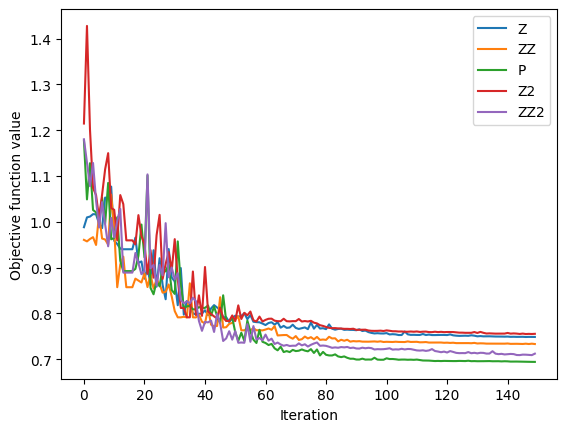

In [36]:
# Plot the objective function values after all fits

plot_objective_function_values()

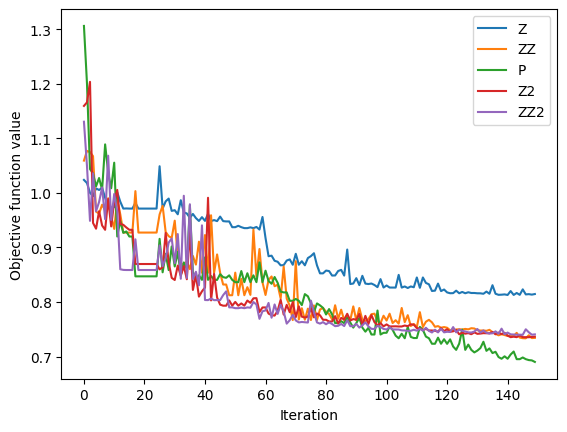

In [37]:
plot_objective_function_values_nloc()

In [38]:
print("VQC with Z feature map and RealAmplitude as ansatz score:", vqc_Z.score(X_test, y_test_np))
print("VQC with ZZ feature map and RealAmplitude as ansatz score:", vqc_ZZ.score(X_test, y_test_np))
print("VQC with Pauli feature map and RealAmplitude as ansatz score:", vqc_P.score(X_test, y_test_np))
print("VQC with Z2 feature map and RealAmplitude as ansatz score:", vqc_Z2.score(X_test, y_test_np))
print("VQC with ZZ2 feature map and RealAmplitude as ansatz score:", vqc_ZZ2.score(X_test, y_test_np))
# print("VQC with RawFeatureVector feature map score:", vqc_amp.score(X_test_amp, y_test_np_amp))

VQC with Z feature map and RealAmplitude as ansatz score: 0.85
VQC with ZZ feature map and RealAmplitude as ansatz score: 0.8166666666666667
VQC with Pauli feature map and RealAmplitude as ansatz score: 0.7333333333333333
VQC with Z2 feature map and RealAmplitude as ansatz score: 0.8333333333333334
VQC with ZZ2 feature map and RealAmplitude as ansatz score: 0.75


In [39]:
print("VQC with Z feature map and NLocal as ansatz score:", vqc_Z_nloc.score(X_test, y_test_np))
print("VQC with ZZ feature map and NLocal as ansatz score:", vqc_ZZ_nloc.score(X_test, y_test_np))
print("VQC with Pauli feature map and NLocal as ansatz score:", vqc_P_nloc.score(X_test, y_test_np))
print("VQC with Z2 feature map and NLocal as ansatz score:", vqc_Z2_nloc.score(X_test, y_test_np))
print("VQC with ZZ2 feature map and NLocal as ansatz score:", vqc_ZZ2_nloc.score(X_test, y_test_np))

VQC with Z feature map and NLocal as ansatz score: 0.7666666666666667
VQC with ZZ feature map and NLocal as ansatz score: 0.8
VQC with Pauli feature map and NLocal as ansatz score: 0.8166666666666667
VQC with Z2 feature map and NLocal as ansatz score: 0.8
VQC with ZZ2 feature map and NLocal as ansatz score: 0.8


In [40]:
def evaluate_with_feature_map(vqc, X_train, y_train, X_test, y_test, feature_map_name):
    # Perform predictions on training and test sets
    y_train_pred = vqc.predict(X_train)
    y_test_pred = vqc.predict(X_test)
    
    # Print classification report and confusion matrix for training set
    print(f"Classification Report for {feature_map_name} Feature Map (Train Set):\n")
    print(classification_report(y_train_np, y_train_pred))
    print("Confusion Matrix for Train Set:")
    print(confusion_matrix(y_train_np, y_train_pred))
    print("\n")
    
    # Print classification report and confusion matrix for test set
    print(f"Classification Report for {feature_map_name} Feature Map (Test Set):\n")
    print(classification_report(y_test_np, y_test_pred))
    print("Confusion Matrix for Test Set:")
    print(confusion_matrix(y_test_np, y_test_pred))
    
    # Print ROC AUC score for test set
    print(f"ROC AUC Score for {feature_map_name} Feature Map (Test Set):")
    print(round(roc_auc_score(y_test_np, y_test_pred), 4))
    print(70*'=')

In [41]:
vqc_models = {'Z': vqc_Z, 'ZZ': vqc_ZZ, 'P': vqc_P, 'Z2': vqc_Z2, 'ZZ2': vqc_ZZ2} #, 'Amp': vqc_amp}

for feature_map_name, vqc_model in vqc_models.items():
    print(f"Evaluating performance for {feature_map_name} Feature Map:\n")
    #if feature_map_name == 'Amp':
    #    evaluate_with_feature_map(vqc_amp, X_train_amp, y_train_np_amp, X_test_amp, y_test_np_amp, feature_map_name)
    #else:
    # Perform predictions and evaluate performance metrics
    evaluate_with_feature_map(vqc_model, X_train, y_train_np, X_test, y_test_np, feature_map_name)

Evaluating performance for Z Feature Map:

Classification Report for Z Feature Map (Train Set):

              precision    recall  f1-score   support

           0       0.82      0.89      0.85        71
           1       0.87      0.80      0.83        69

    accuracy                           0.84       140
   macro avg       0.85      0.84      0.84       140
weighted avg       0.85      0.84      0.84       140

Confusion Matrix for Train Set:
[[63  8]
 [14 55]]


Classification Report for Z Feature Map (Test Set):

              precision    recall  f1-score   support

           0       0.81      0.90      0.85        29
           1       0.89      0.81      0.85        31

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60

Confusion Matrix for Test Set:
[[26  3]
 [ 6 25]]
ROC AUC Score for Z Feature Map (Test Set):
0.8515
Evaluating performance for ZZ Feature Map:

In [42]:
vqc_models_nloc = {'Z': vqc_Z_nloc, 'ZZ': vqc_ZZ_nloc, 'P': vqc_P_nloc, 'Z2': vqc_Z2_nloc, 'ZZ2': vqc_ZZ2_nloc} #, 'Amp': vqc_amp}

for feature_map_name, vqc_model in vqc_models_nloc.items():
    print(f"Evaluating performance for {feature_map_name} Feature Map:\n")
    #if feature_map_name == 'Amp':
    #    evaluate_with_feature_map(vqc_amp, X_train_amp, y_train_np_amp, X_test_amp, y_test_np_amp, feature_map_name)
    #else:
    # Perform predictions and evaluate performance metrics
    evaluate_with_feature_map(vqc_model, X_train, y_train_np, X_test, y_test_np, feature_map_name)

Evaluating performance for Z Feature Map:

Classification Report for Z Feature Map (Train Set):

              precision    recall  f1-score   support

           0       0.79      0.87      0.83        71
           1       0.85      0.77      0.81        69

    accuracy                           0.82       140
   macro avg       0.82      0.82      0.82       140
weighted avg       0.82      0.82      0.82       140

Confusion Matrix for Train Set:
[[62  9]
 [16 53]]


Classification Report for Z Feature Map (Test Set):

              precision    recall  f1-score   support

           0       0.71      0.86      0.78        29
           1       0.84      0.68      0.75        31

    accuracy                           0.77        60
   macro avg       0.78      0.77      0.77        60
weighted avg       0.78      0.77      0.77        60

Confusion Matrix for Test Set:
[[25  4]
 [10 21]]
ROC AUC Score for Z Feature Map (Test Set):
0.7697
Evaluating performance for ZZ Feature Map:

AUC (100 iterations, 140 training samples, 60 testing samples):

- COBYLA:       'Z' 0.7709;     'ZZ' 0.7063;     'P' 0.7075;      'Amp' 0.8526

- SPSA:         'Z' 0.7397;     'ZZ' 0.7836;     'P' 0.7063;      'Amp' 0.5868     more time to compute than COBYLA

- SLSQP:        too much time

AUC (200 iterations, 140 training samples, 60 testing samples):

- COBYLA:       'Z' 0.8515;     'ZZ' 0.7503;     'P' 0.9021;      'Amp' 0.8192

# TODO CONFRONTO RISULTATI

Now we try different classical machine learning models

In [43]:
%%time

def train_test(ML_model):
    print(20*' ', ML_model,'\n')
    ML_model.fit(X_train, y_train_np)                         
    
    y_train_pred = ML_model.predict(X_train)       
    y_test_pred = ML_model.predict(X_test)
    
    
    print(classification_report(y_train_np, y_train_pred))
    print("Confusion Matrix for Train Set:")    
    print(confusion_matrix(y_train_np, y_train_pred))

    print(classification_report(y_test_np, y_test_pred))
    print("Confusion Matrix for Test Set:")
    print(confusion_matrix(y_test_np, y_test_pred))
    print(f"ROC AUC Score (Test Set):")
    print(round(roc_auc_score(y_test_np, y_test_pred),2))
    
    print(70*'=')
    
print(70*'=')
ML_model = linear_model.LogisticRegression()         
train_test(ML_model)


ML_model = MLPClassifier()                            
train_test(ML_model)


ML_model = svm.SVC() 
train_test(ML_model)


ML_model = RandomForestClassifier()
train_test(ML_model)


                     LogisticRegression() 

              precision    recall  f1-score   support

           0       0.82      0.89      0.85        71
           1       0.87      0.80      0.83        69

    accuracy                           0.84       140
   macro avg       0.85      0.84      0.84       140
weighted avg       0.85      0.84      0.84       140

Confusion Matrix for Train Set:
[[63  8]
 [14 55]]
              precision    recall  f1-score   support

           0       0.81      0.90      0.85        29
           1       0.89      0.81      0.85        31

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60

Confusion Matrix for Test Set:
[[26  3]
 [ 6 25]]
ROC AUC Score (Test Set):
0.85
                     MLPClassifier() 

              precision    recall  f1-score   support

           0       0.80      0.89      0.84        71
           1       0.8

# TODO CONFRONTO CON MODELLI CLASSICI E CONSIDERAZIONI

# NOISY CASE #

service = QiskitRuntimeService(channel='ibm_quantum')
sim = "ibmq_qasm_simulator"

backend = service.get_backend("ibmq_qasm_simulator")

options = Options()

# Set number of shots, optimization_level and resilience_level
options.execution.shots = 1000
options.optimization_level = 3
options.resilience_level = 0 

fake_backend = FakeAuckland()

noise_model = NoiseModel.from_backend(backend)
basis_gates=backend.configuration().basis_gates
coupling_map=backend.configuration().coupling_map


options.simulator = {
    "noise_model": noise_model,
    "basis_gates":basis_gates,
    "coupling_map": coupling_map,
    "seed_simulator": 42
}

sampler = Sampler(options=options, backend=backend)
#sampler = Sampler()

initial_point_amp=np.random.random(pqc_amp.num_parameters)

initial_point=np.random.random(pqc.num_parameters)

optimizer = COBYLA(maxiter=2)

objective_func_vals_noisy = {'Z': [], 'ZZ': [], 'P': []}#, 'Amp': []}

def callback_noisy(feature_map_name, obj_func_eval):
    # Append objective function value to the corresponding list based on the feature map name
    objective_func_vals[feature_map_name].append(obj_func_eval)

def plot_objective_function_values_noisy():
    clear_output(wait=True)
    
    # Plot all objective function values
    
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    for feature_map_name, obj_func_vals in objective_func_vals_noisy.items():
        plt.plot(range(len(obj_func_vals)), obj_func_vals, label=feature_map_name)
    plt.legend()
    plt.show()

vqc_noisy_models = {
    VQC(sampler=sampler, feature_map=Z, ansatz=pqc, initial_point=initial_point, callback=lambda weights, obj_func_eval: callback_noisy('Z', obj_func_eval)),
    VQC(sampler=sampler, feature_map=ZZ,ansatz=pqc, initial_point=initial_point, callback=lambda weights, obj_func_eval: callback_noisy('ZZ', obj_func_eval)),
    VQC(sampler=sampler, feature_map=P, ansatz=pqc, initial_point=initial_point, callback=lambda weights, obj_func_eval: callback_noisy('P', obj_func_eval)),
    #VQC(sampler=sampler, feature_map=amp_enc, ansatz=pqc_amp, initial_point=initial_point_amp, callback=lambda weights, obj_func_eval: callback_noisy('Amp', obj_func_eval))
}

vqc_models = {'Z': vqc_Z, 'ZZ': vqc_ZZ, 'P': vqc_P}#, 'Amp': vqc_amp}

for vqc in vqc_noisy_models:
    with Session(service=service, backend=sim) as session:
        vqc = vqc

        if vqc.feature_map == amp_enc:
            vqc.fit(X_train_amp, y_train_np_amp)
            evaluate_with_feature_map(vqc, X_train_amp, y_train_np_amp, X_test_amp, y_test_np_amp, feature_map_name)
        else:
            vqc.fit(X_train, y_train_np)
            evaluate_with_feature_map(vqc, X_train, y_train_np, X_test, y_test_np, feature_map_name)
    

        print("Experiment complete.".ljust(30))
        session.close()

plot_objective_function_values_noisy()

for vqc in vqc_noisy_models:
    with Session(service=service, backend=sim) as session:
        vqc = vqc

        vqc.fit(X_train, y_train_np)
        evaluate_with_feature_map(vqc, X_train, y_train_np, X_test, y_test_np, feature_map_name)
    

        print("Experiment complete.".ljust(30))
        session.close()

plot_objective_function_values_noisy()

In [44]:
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import FakeVigo
from qiskit.primitives import BackendSampler

device_backend = FakeVigo()
sim_vigo = AerSimulator.from_backend(device_backend)


In [45]:
sim_vigo.shots = 1000
sim_vigo.optimization_level = 3

In [46]:
sampler = BackendSampler(backend=sim_vigo)

In [47]:
initial_point=np.random.random(pqc.num_parameters)

objective_func_vals = {'Z': [], 'ZZ': [], 'P': [], 'Z2' : [], 'ZZ2' : []}

In [48]:
vqc_Z = VQC(
    sampler=sampler,
    feature_map=Z,
    ansatz=pqc,
    initial_point=initial_point,
    optimizer=optimizer,
    callback=lambda weights, obj_func_eval: callback('Z', obj_func_eval),
)

vqc_ZZ = VQC(
    sampler=sampler,
    feature_map=ZZ,
    ansatz=pqc,
    initial_point=initial_point,
    optimizer=optimizer,
    callback=lambda weights, obj_func_eval: callback('ZZ', obj_func_eval),
)

vqc_P = VQC(
    sampler=sampler,
    feature_map=P,
    ansatz=pqc,
    initial_point=initial_point,
    optimizer=optimizer,
    callback=lambda weights, obj_func_eval: callback('P', obj_func_eval),
)

vqc_Z2 = VQC(
    sampler=sampler,
    feature_map=Z2,
    ansatz=pqc,
    initial_point=initial_point,
    optimizer=optimizer,
    callback=lambda weights, obj_func_eval: callback('Z2', obj_func_eval),
)

vqc_ZZ2 = VQC(
    sampler=sampler,
    feature_map=ZZ2,
    ansatz=pqc,
    initial_point=initial_point,
    optimizer=optimizer,
    callback=lambda weights, obj_func_eval: callback('ZZ2', obj_func_eval),
)

In [49]:
initial_point_nloc=np.random.random(nlocal.num_parameters)

objective_func_vals_nloc = {'Z': [], 'ZZ': [], 'P': [], 'Z2' : [], 'ZZ2' : []}

In [50]:
vqc_Z_nloc = VQC(
    sampler=sampler,
    feature_map=Z,
    ansatz=nlocal,
    initial_point=initial_point_nloc,
    optimizer=optimizer,
    callback=lambda weights, obj_func_eval: callback_nloc('Z', obj_func_eval),
)

vqc_ZZ_nloc = VQC(
    sampler=sampler,
    feature_map=ZZ,
    ansatz=nlocal,
    initial_point=initial_point_nloc,
    optimizer=optimizer,
    callback=lambda weights, obj_func_eval: callback_nloc('ZZ', obj_func_eval),
)

vqc_P_nloc = VQC(
    sampler=sampler,
    feature_map=P,
    ansatz=nlocal,
    initial_point=initial_point_nloc,
    optimizer=optimizer,
    callback=lambda weights, obj_func_eval: callback_nloc('P', obj_func_eval),
)

vqc_Z2_nloc = VQC(
    sampler=sampler,
    feature_map=Z2,
    ansatz=nlocal,
    initial_point=initial_point_nloc,
    optimizer=optimizer,
    callback=lambda weights, obj_func_eval: callback_nloc('Z2', obj_func_eval),
)

vqc_ZZ2_nloc = VQC(
    sampler=sampler,
    feature_map=ZZ2,
    ansatz=nlocal,
    initial_point=initial_point_nloc,
    optimizer=optimizer,
    callback=lambda weights, obj_func_eval: callback_nloc('ZZ2', obj_func_eval),
)

In [51]:
%%time
vqc_Z.fit(X_train, y_train_np)

CPU times: user 5min 31s, sys: 3min 20s, total: 8min 51s
Wall time: 4min 27s


In [52]:
%%time
vqc_ZZ.fit(X_train, y_train_np)

CPU times: user 10min 29s, sys: 3min 39s, total: 14min 9s
Wall time: 9min 21s


In [53]:
%%time
vqc_P.fit(X_train, y_train_np)

CPU times: user 11min 25s, sys: 3min 40s, total: 15min 5s
Wall time: 10min 16s


In [54]:
%%time
vqc_Z2.fit(X_train, y_train_np)

CPU times: user 6min 7s, sys: 3min 37s, total: 9min 45s
Wall time: 4min 54s


In [55]:
%%time
vqc_ZZ2.fit(X_train, y_train_np)

CPU times: user 9min 6s, sys: 3min 12s, total: 12min 19s
Wall time: 8min 6s


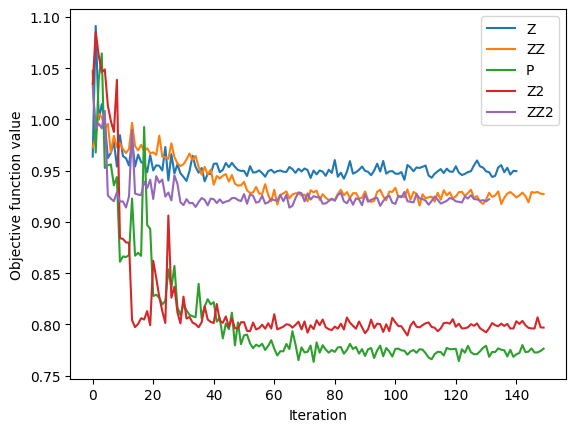

In [56]:
plot_objective_function_values()

In [57]:
%%time
vqc_Z_nloc.fit(X_train, y_train_np)

CPU times: user 6min 50s, sys: 3min 28s, total: 10min 18s
Wall time: 5min 23s


In [58]:
%%time
vqc_ZZ_nloc.fit(X_train, y_train_np)

CPU times: user 11min 13s, sys: 3min 32s, total: 14min 45s
Wall time: 9min 49s


In [59]:
%%time
vqc_P_nloc.fit(X_train, y_train_np)

CPU times: user 12min 17s, sys: 3min 27s, total: 15min 44s
Wall time: 10min 47s


In [60]:
%%time
vqc_Z2_nloc.fit(X_train, y_train_np)

CPU times: user 7min 10s, sys: 3min 26s, total: 10min 36s
Wall time: 5min 30s


In [61]:
%%time
vqc_ZZ2_nloc.fit(X_train, y_train_np)

CPU times: user 11min 28s, sys: 3min 11s, total: 14min 40s
Wall time: 10min 2s


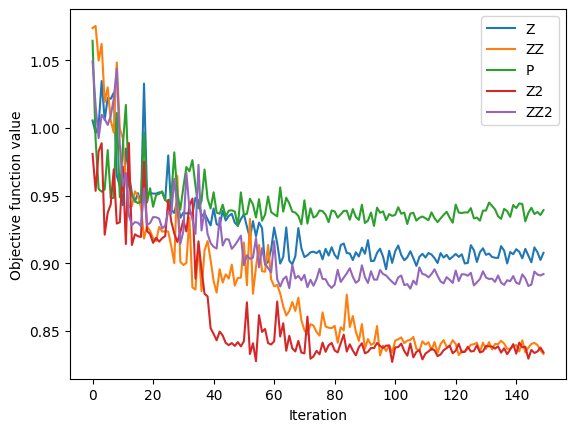

In [62]:
plot_objective_function_values_nloc()

In [63]:
print("VQC with Z feature map and RealAmplitude as ansatz score:", vqc_Z.score(X_test, y_test_np))
print("VQC with ZZ feature map and RealAmplitude as ansatz score:", vqc_ZZ.score(X_test, y_test_np))
print("VQC with Pauli feature map and RealAmplitude as ansatz score:", vqc_P.score(X_test, y_test_np))
print("VQC with Z2 feature map and RealAmplitude as ansatz score:", vqc_Z2.score(X_test, y_test_np))
print("VQC with ZZ2 feature map and RealAmplitude as ansatz score:", vqc_ZZ2.score(X_test, y_test_np))

VQC with Z feature map and RealAmplitude as ansatz score: 0.7666666666666667
VQC with ZZ feature map and RealAmplitude as ansatz score: 0.5666666666666667
VQC with Pauli feature map and RealAmplitude as ansatz score: 0.7833333333333333
VQC with Z2 feature map and RealAmplitude as ansatz score: 0.8333333333333334
VQC with ZZ2 feature map and RealAmplitude as ansatz score: 0.7


In [64]:
print("VQC with Z feature map and NLocal as ansatz score:", vqc_Z_nloc.score(X_test, y_test_np))
print("VQC with ZZ feature map and NLocal as ansatz score:", vqc_ZZ_nloc.score(X_test, y_test_np))
print("VQC with Pauli feature map and NLocal as ansatz score:", vqc_P_nloc.score(X_test, y_test_np))
print("VQC with Z2 feature map and NLocal as ansatz score:", vqc_Z2_nloc.score(X_test, y_test_np))
print("VQC with ZZ2 feature map and NLocal as ansatz score:", vqc_ZZ2_nloc.score(X_test, y_test_np))

VQC with Z feature map and NLocal as ansatz score: 0.7333333333333333
VQC with ZZ feature map and NLocal as ansatz score: 0.7166666666666667
VQC with Pauli feature map and NLocal as ansatz score: 0.65
VQC with Z2 feature map and NLocal as ansatz score: 0.8833333333333333
VQC with ZZ2 feature map and NLocal as ansatz score: 0.7333333333333333


In [65]:
vqc_models = {'Z': vqc_Z, 'ZZ': vqc_ZZ, 'P': vqc_P, 'Z2': vqc_Z2, 'ZZ2': vqc_ZZ2} #, 'Amp': vqc_amp}

for feature_map_name, vqc_model in vqc_models.items():
    print(f"Evaluating performance for {feature_map_name} Feature Map:\n")
    #if feature_map_name == 'Amp':
    #    evaluate_with_feature_map(vqc_amp, X_train_amp, y_train_np_amp, X_test_amp, y_test_np_amp, feature_map_name)
    #else:
    # Perform predictions and evaluate performance metrics
    evaluate_with_feature_map(vqc_model, X_train, y_train_np, X_test, y_test_np, feature_map_name)

Evaluating performance for Z Feature Map:

Classification Report for Z Feature Map (Train Set):

              precision    recall  f1-score   support

           0       0.78      0.69      0.73        71
           1       0.71      0.80      0.75        69

    accuracy                           0.74       140
   macro avg       0.75      0.74      0.74       140
weighted avg       0.75      0.74      0.74       140

Confusion Matrix for Train Set:
[[49 22]
 [14 55]]


Classification Report for Z Feature Map (Test Set):

              precision    recall  f1-score   support

           0       0.83      0.66      0.73        29
           1       0.73      0.87      0.79        31

    accuracy                           0.77        60
   macro avg       0.78      0.76      0.76        60
weighted avg       0.78      0.77      0.76        60

Confusion Matrix for Test Set:
[[19 10]
 [ 4 27]]
ROC AUC Score for Z Feature Map (Test Set):
0.7631
Evaluating performance for ZZ Feature Map:

In [66]:
vqc_models_nloc = {'Z': vqc_Z_nloc, 'ZZ': vqc_ZZ_nloc, 'P': vqc_P_nloc, 'Z2': vqc_Z2_nloc, 'ZZ2': vqc_ZZ2_nloc} #, 'Amp': vqc_amp}

for feature_map_name, vqc_model in vqc_models_nloc.items():
    print(f"Evaluating performance for {feature_map_name} Feature Map:\n")
    #if feature_map_name == 'Amp':
    #    evaluate_with_feature_map(vqc_amp, X_train_amp, y_train_np_amp, X_test_amp, y_test_np_amp, feature_map_name)
    #else:
    # Perform predictions and evaluate performance metrics
    evaluate_with_feature_map(vqc_model, X_train, y_train_np, X_test, y_test_np, feature_map_name)

Evaluating performance for Z Feature Map:

Classification Report for Z Feature Map (Train Set):

              precision    recall  f1-score   support

           0       0.59      0.89      0.71        71
           1       0.76      0.38      0.50        69

    accuracy                           0.64       140
   macro avg       0.68      0.63      0.61       140
weighted avg       0.68      0.64      0.61       140

Confusion Matrix for Train Set:
[[63  8]
 [43 26]]


Classification Report for Z Feature Map (Test Set):

              precision    recall  f1-score   support

           0       0.63      0.90      0.74        29
           1       0.84      0.52      0.64        31

    accuracy                           0.70        60
   macro avg       0.74      0.71      0.69        60
weighted avg       0.74      0.70      0.69        60

Confusion Matrix for Test Set:
[[26  3]
 [15 16]]
ROC AUC Score for Z Feature Map (Test Set):
0.7063
Evaluating performance for ZZ Feature Map: